In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier

In [49]:
def determine_covid_outcome(new_cases_per_100k, new_admits_per_100k, percent_beds_100k):
    if new_cases_per_100k < 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > .10): # data is not *100
            if (new_admits_per_100k >= 20) | (percent_beds_100k >= 15):
                return "High"
            else:
                return "Medium"
        else:
            return "Low"
    elif 200 <= new_cases_per_100k:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > .10):
            if (new_admits_per_100k >= 10) | (percent_beds_100k >= 10):
                return "High"
            else:
                return "Medium"




In [50]:
### this code it's ANY in the x week period 

def prep_training_test_data_period(data, proportion, no_weeks, weeks_in_futre, if_train, geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        for week_y in range(week+1, test_week+1):
                y_weeks_to_check.append('_' + num2words(week_y) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
            train_week = w2n.word_to_num(x_week.replace("_", ""))
            target_week =  w2n.word_to_num(y_week.replace("_", ""))
            y_weeks_to_check = []
            for week_to_check in range(train_week + 1, target_week + 1):
                y_weeks_to_check.append('_' + num2words(week_to_check) + '_')

            y_weeks_to_check = [week + 'beds_over_15_100k' for week in y_weeks_to_check]
            columns_to_check = [col for col in data.columns if any(week in col for week in y_weeks_to_check)]
            y_over_in_period = data[columns_to_check].apply(max, axis=1)
            data_y = pd.concat([data_y, y_over_in_period], axis=1)
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week, inlcuding it as a feature

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -1)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)

Data prep
For the CDC, they only use three metrics: new_cases_per_100k, new_admits_per_100k, percent_beds_100k

In [51]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)
data_by_HSA.columns

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2180/2861294902.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


Index(['Unnamed: 0', 'date', 'HSA_ID', 'health_service_area',
       'health_service_area_population', 'cases_avg', 'deaths_avg',
       'cases_avg_per_100k', 'deaths_avg_per_100k', 'POPESTIMATE2019', 'ymd',
       'year', 'week', 'year_wk', 'admits_confirmed_avg', 'perc_covid',
       'admits_confirmed_100K', 'icu_confirmed_avg', 'icu_100K', 'beds_100k',
       'cdc_flag_1', 'cdc_flag_2', 'cdc_flag', 'deaths_21_lag_100k',
       'icu_21_lag_100K', 'cases_lag_21_100K', 'admits_7_lag', 'admits_7d_ago',
       'admits_21d_ago', 'admits_28d_ago', 'dotw', 'chk', 'county_rank',
       'deaths_21_lag_100k_14d', 'deaths_weekly', 'admits_weekly',
       'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid_100', 'cfr',
       'half_zeke_time_3', 'chk2', 'zeke_time_3', 'two_zeke_time_3',
       'icu_2_time_3', 'perc_covid_10_time_3', 'change_admits', 'change_perc',
       'change_cases', 'zeke_time_3_14d', 'two_zeke_time_3_14d', 'state',
       'weight', 'weight_alt'],
      dtype='object')

In [52]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'cases_weekly', 'perc_covid'])
for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i
    
data_by_HSA_cases = data_by_HSA[['HSA_ID', 'week', 'cases_weekly']]
data_by_HSA_cases = data_by_HSA_cases.pivot_table(index= 'week', columns='HSA_ID', values='cases_weekly')

data_by_HSA_admissions = data_by_HSA[['HSA_ID', 'week', 'admits_weekly']]
data_by_HSA_admissions = data_by_HSA_admissions.pivot_table(index= 'week', columns='HSA_ID', values='admits_weekly')

data_by_HSA_perc_covid = data_by_HSA[['HSA_ID', 'week', 'perc_covid']]
data_by_HSA_perc_covid = data_by_HSA_perc_covid.pivot_table(index= 'week', columns='HSA_ID', values='perc_covid')



data_data_cases_admits_weekly = pd.merge(data_by_HSA_cases, data_by_HSA_admissions, on='week')
new_column_names = [col.replace('_x', '_cases') for col in data_data_cases_admits_weekly.columns]
data_data_cases_admits_weekly.rename(columns=dict(zip(data_data_cases_admits_weekly.columns, new_column_names)), inplace=True)
new_column_names = [col.replace('_y', '_admits') for col in data_data_cases_admits_weekly.columns]
data_data_cases_admits_weekly.rename(columns=dict(zip(data_data_cases_admits_weekly.columns, new_column_names)), inplace=True)

old_column_names = data_by_HSA_perc_covid.columns
new_column_names = [str(col) + '_percent_beds_covid' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_perc_covid.rename(columns=new_column_names, inplace=True)

data_by_HSA_cases_admits_perc = pd.merge(data_data_cases_admits_weekly, data_by_HSA_perc_covid, on='week')
data_by_HSA_cases_admits_perc = data_by_HSA_cases_admits_perc.reset_index()
#data_by_HSA_cases_admits_perc.columns = data_by_HSA_cases_admits_perc.columns.str.replace(',', '')

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2180/1329533506.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


In [53]:
column_names = ['HSA_ID']
categories_for_subsetting = ['cases', 'admits', 'percent_beds_covid']

for week in range(1, len(data_by_HSA_cases_admits_perc) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)

all_HSA_ID_weekly_data = pd.DataFrame(index=range(51), columns=column_names)

x = 0

for HSA in data_by_HSA['HSA_ID'].unique():
    matching_indices = [i for i, HSA_col in enumerate(data_by_HSA_cases_admits_perc) if HSA_col == HSA]
    all_HSA_ID_weekly_data.loc[x, 'HSA_ID'] = HSA
    columns_to_subset =  [f'{HSA}_{category}' for category in categories_for_subsetting]
 
    j = 1
    try:
        for row in range(len(data_by_HSA_cases_admits_perc.loc[:, columns_to_subset])):
            all_HSA_ID_weekly_data.iloc[x, j:j + len(categories_for_subsetting)] = data_by_HSA_cases_admits_perc.loc[row,columns_to_subset]
            j += 3
    except:
        pass
    x += 1



weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

In [54]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data, [3,2], no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data, [3,2], no_weeks = range(int(123*2/3) + 1, 123), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
weights = weights[0].to_numpy()


In [56]:
def determine_covid_outcome(new_cases_per_100k, new_admits_per_100k, percent_beds_100k):

    ## here we're saying that High = >15 per 100k
    if new_cases_per_100k < 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > .10): # data is not *100
            if (new_admits_per_100k >= 20) | (percent_beds_100k >= 15):
                #return "High"
                return 1
            else:
                return 0
                #return "Medium"
        else:
                return 0
            #return "Low"
    elif 200 <= new_cases_per_100k:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > .10):
            if (new_admits_per_100k >= 10) | (percent_beds_100k >= 10):
                #return "High"
                return 1
            else:
                return 0
                #return "Medium"


Just compare the High vs >15 per 100k in the week of interest (no time lag)

In [57]:
# Assuming you have a list called 'categories_for_subsetting' that contains the categories you want to subset
CDC_predictions = pd.DataFrame(index=data_by_HSA_cases_admits_perc['week'])

for HSA in data_by_HSA['HSA_ID'].unique():
    matching_indices = [i for i, HSA_col in enumerate(data_by_HSA_cases_admits_perc.columns) if HSA_col == HSA]
    columns_to_subset = [f'{HSA}_{category}' for category in categories_for_subsetting]
    j = 0
    try:
        for idx, row in data_by_HSA_cases_admits_perc.iterrows():
            # Pass each column from 'columns_to_subset' into the 'determine_covid_outcome' function
            outcome = determine_covid_outcome(row[columns_to_subset[0]], row[columns_to_subset[1]], row[columns_to_subset[2]])
            CDC_predictions.loc[idx, f'{HSA}_outcome'] = outcome
    except Exception as e:
        print(f"Error occurred for HSA {HSA}: {e}")

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2180/1452187041.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  CDC_predictions.loc[idx, f'{HSA}_outcome'] = outcome
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2180/1452187041.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  CDC_predictions.loc[idx, f'{HSA}_outcome'] = outcome
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2180/1452187041.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

In [58]:
data_by_HSA_over_15_100k = data_by_HSA[['HSA_ID', 'week', 'beds_over_15_100k']]
data_by_HSA_over_15_100k = data_by_HSA_over_15_100k.pivot_table(index= 'week', columns='HSA_ID', values='beds_over_15_100k')

old_column_names = data_by_HSA_over_15_100k.columns
new_column_names = [str(col) + '_beds_over_15_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_15_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_over_15_100k = data_by_HSA_over_15_100k.reset_index()
actual_hospital_capacity = data_by_HSA_over_15_100k.filter(like="beds_over_15_100k")

# Create a new DataFrame with the subset columns
actual_hospital_capacity = pd.DataFrame(actual_hospital_capacity)


In [59]:
actual_hospital_capacity.fillna(0, inplace=True)
CDC_predictions.fillna(0, inplace=True)


In [60]:
comparison_result = actual_hospital_capacity.values == CDC_predictions.values
correct_predictions = comparison_result.sum()

# Calculate the total number of predictions (total number of elements in the DataFrames)
total_predictions = actual_hospital_capacity.size
accuracy = correct_predictions / total_predictions
accuracy

0.5635678198156504

In [61]:
# Convert predicted probabilities to binary predictions using a threshold (e.g., 0.5)

# Calculate AUROC
auroc = roc_auc_score(actual_hospital_capacity.values.ravel(), CDC_predictions.values.ravel())

# Calculate accuracy
accuracy = accuracy_score(actual_hospital_capacity.values.ravel(), CDC_predictions.values.ravel())

# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_hospital_capacity.values.ravel(), CDC_predictions.values.ravel())

# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])


In [62]:
print("sensitivity:", sensitivity)
print("specificity:", specificity)
print("accuracy:", accuracy)
print("auroc:", auroc)

print("ppv:", ppv)
print("npv:", npv)

sensitivity: 0.42439316595478693
specificity: 0.9605184965086911
accuracy: 0.5635678198156504
auroc: 0.692455831231739
ppv: 0.9684129200962767
npv: 0.3691106575510612


Now look at t + 3 weeks, with the CDC community levels as the feature and whether the capacity execeeds 15 per 100k in the next 3 weeks as the outcome

In [63]:
def determine_covid_outcome(new_cases_per_100k, new_admits_per_100k, percent_beds_100k):

    ## here we're saying that High = >15 per 100k
    if new_cases_per_100k < 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > 10):
            if (new_admits_per_100k >= 20) | (percent_beds_100k >= 15):
                return "High"
            else:
                return "Medium"
        else:
            return "Low"
    elif 200 <= new_cases_per_100k:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > 10):
            if (new_admits_per_100k >= 10) | (percent_beds_100k >= 10):
                return "High"
            else:
                return "Medium"

1. CDC predictions

In [64]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'cases_weekly', 'perc_covid'])
for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i
    
data_by_HSA_cases = data_by_HSA[['HSA_ID', 'week', 'cases_weekly']]
data_by_HSA_cases = data_by_HSA_cases.pivot_table(index= 'week', columns='HSA_ID', values='cases_weekly')

data_by_HSA_admissions = data_by_HSA[['HSA_ID', 'week', 'admits_weekly']]
data_by_HSA_admissions = data_by_HSA_admissions.pivot_table(index= 'week', columns='HSA_ID', values='admits_weekly')

data_by_HSA_perc_covid = data_by_HSA[['HSA_ID', 'week', 'perc_covid']]
data_by_HSA_perc_covid = data_by_HSA_perc_covid.pivot_table(index= 'week', columns='HSA_ID', values='perc_covid')



data_data_cases_admits_weekly = pd.merge(data_by_HSA_cases, data_by_HSA_admissions, on='week')
new_column_names = [col.replace('_x', '_cases') for col in data_data_cases_admits_weekly.columns]
data_data_cases_admits_weekly.rename(columns=dict(zip(data_data_cases_admits_weekly.columns, new_column_names)), inplace=True)
new_column_names = [col.replace('_y', '_admits') for col in data_data_cases_admits_weekly.columns]
data_data_cases_admits_weekly.rename(columns=dict(zip(data_data_cases_admits_weekly.columns, new_column_names)), inplace=True)

old_column_names = data_by_HSA_perc_covid.columns
new_column_names = [str(col) + '_percent_beds_covid' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_perc_covid.rename(columns=new_column_names, inplace=True)

data_by_HSA_cases_admits_perc = pd.merge(data_data_cases_admits_weekly, data_by_HSA_perc_covid, on='week')
data_by_HSA_cases_admits_perc = data_by_HSA_cases_admits_perc.reset_index()
#data_by_HSA_cases_admits_perc.columns = data_by_HSA_cases_admits_perc.columns.str.replace(',', '')

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2180/1329533506.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


In [65]:
# Assuming you have a list called 'categories_for_subsetting' that contains the categories you want to subset
CDC_predictions = pd.DataFrame(index=data_by_HSA_cases_admits_perc['week'])
categories_for_subsetting = ['cases', 'admits', 'percent_beds_covid']
for HSA in data_by_HSA['HSA_ID'].unique():
    matching_indices = [i for i, HSA_col in enumerate(data_by_HSA_cases_admits_perc.columns) if HSA_col == HSA]
    columns_to_subset =  [f'{HSA}_{category}' for category in categories_for_subsetting]
    j = 0
    try:
        for idx, row in data_by_HSA_cases_admits_perc.iterrows():
            # Pass each column from 'columns_to_subset' into the 'determine_covid_outcome' function
            outcome = determine_covid_outcome(row[columns_to_subset[0]], row[columns_to_subset[1]], row[columns_to_subset[2]]*100)
            CDC_predictions.loc[idx, f'{HSA}_category'] = outcome
    except Exception as e:
        print(f"Error occurred for HSA {HSA}: {e}")

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2180/2538373281.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  CDC_predictions.loc[idx, f'{HSA}_category'] = outcome
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2180/2538373281.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  CDC_predictions.loc[idx, f'{HSA}_category'] = outcome
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2180/2538373281.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

In [66]:
categories_for_subsetting = ['category']
categories_for_subsetting

['category']

In [67]:
column_names = ['HSA_ID']
categories_for_subsetting = ['category']

for week in range(1, len(CDC_predictions) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)

CDC_predictions_by_week = pd.DataFrame(index=range(51), columns=column_names)

x = 0

for HSA in data_by_HSA['HSA_ID'].unique():
    matching_indices = [i for i, HSA_col in enumerate(CDC_predictions) if HSA_col == HSA]
    CDC_predictions_by_week.loc[x, 'HSA_ID'] = HSA
    columns_to_subset =  [f'{HSA}_{category}' for category in categories_for_subsetting]
 
    j = 1
    try:
        for row in range(len(CDC_predictions.loc[:, columns_to_subset])):
            CDC_predictions_by_week.iloc[x, j:j + len(categories_for_subsetting)] = CDC_predictions.loc[row,columns_to_subset]
            j += len(categories_for_subsetting)
    except:
        pass
    x += 1

2. Outcomes: over/under 15 per 100k 

In [68]:
data_by_HSA_over_15_100k = data_by_HSA[['HSA_ID', 'week', 'beds_over_15_100k']]
data_by_HSA_over_15_100k = data_by_HSA_over_15_100k.pivot_table(index= 'week', columns='HSA_ID', values='beds_over_15_100k')

old_column_names = data_by_HSA_over_15_100k.columns
new_column_names = [str(col) + '_beds_over_15_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_15_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_over_15_100k = data_by_HSA_over_15_100k.reset_index()
column_names = ['HSA_ID']
categories_for_subsetting = ['beds_over_15_100k']

for week in range(1, len(data_by_HSA_over_15_100k) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)

all_HSA_ID_weekly_data = pd.DataFrame(index=range(51), columns=column_names)

x = 0

categories_for_subsetting = ['beds_over_15_100k']
for HSA in data_by_HSA['HSA_ID'].unique():
    matching_indices = [i for i, HSA_col in enumerate(data_by_HSA_over_15_100k) if HSA_col == HSA]
    all_HSA_ID_weekly_data.loc[x, 'HSA_ID'] = HSA
    columns_to_subset =  tuple([f'{HSA}_{category}' for category in categories_for_subsetting]) 
    columns_to_subset =  [f'{HSA}_{category}' for category in categories_for_subsetting]
 
    j = 1
    try:
        for row in range(len(data_by_HSA_over_15_100k.loc[:, columns_to_subset])):
            all_HSA_ID_weekly_data.iloc[x, j:j + len(categories_for_subsetting)] = data_by_HSA_over_15_100k.loc[row,columns_to_subset]
            j += 1
    except:
        pass
    x += 1

3. Merge data and add weights

In [21]:
CDC_predictions_outcome = pd.merge(CDC_predictions_by_week, all_HSA_ID_weekly_data, on='HSA_ID')
weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
CDC_predictions_outcome = CDC_predictions_outcome.join(weights_df['weight'])

4. Create train/test data - period

In [69]:
## this code it's ANY in the x week period 

def prep_training_test_data_period(data, proportion, no_weeks, weeks_in_futre, if_train, geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        for week_y in range(week+1, test_week+1):
                y_weeks_to_check.append('_' + num2words(week_y) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
            train_week = w2n.word_to_num(x_week.replace("_", ""))
            target_week =  w2n.word_to_num(y_week.replace("_", ""))
            y_weeks_to_check = []
            for week_to_check in range(train_week + 1, target_week + 1):
                y_weeks_to_check.append('_' + num2words(week_to_check) + '_')

            y_weeks_to_check = [week + 'beds_over_15_100k' for week in y_weeks_to_check]
            columns_to_check = [col for col in data.columns if any(week in col for week in y_weeks_to_check)]
            y_over_in_period = data[columns_to_check].apply(max, axis=1)
            data_y = pd.concat([data_y, y_over_in_period], axis=1)
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights "target" for that week

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -2)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)

In [70]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(CDC_predictions_outcome, [3,2], no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(CDC_predictions_outcome, [3,2], no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
weights = weights[0]

In [71]:
encoder = OneHotEncoder(sparse_output= False)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)


5. Train the model - period

Accuracy: 0.5430401863715784
auROC: 0.5430401863715784
[[ 5516   585]
 [11184  8470]]


[Text(0.6, 0.8333333333333334, 'x[1] <= 0.5\ngini = 0.5\nsamples = 60760\nvalue = [37.833, 37.833]'),
 Text(0.4, 0.5, 'x[0] <= 0.5\ngini = 0.232\nsamples = 35909\nvalue = [3.755, 24.332]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.402\nsamples = 7817\nvalue = [1.994, 5.172]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.154\nsamples = 28092\nvalue = [1.76, 19.16]'),
 Text(0.8, 0.5, 'gini = 0.406\nsamples = 24851\nvalue = [34.078, 13.502]')]

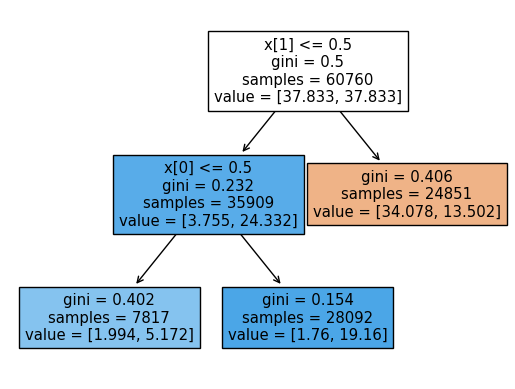

In [25]:
# Create a decision tree classifier

param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 15),
    'min_samples_split':  np.arange(2, 100), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 100) #100, 200, 300, 400, 500], #np.arange(500, 200)
}

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test[0], y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, filled=True)

4b. Create the train/test set for exactly 3 weeks away

In [73]:
### this code it's exactly in  x weeks 
def prep_training_test_data(data, proportion, no_weeks, weeks_in_futre, if_train, geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15

            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and  "target" for that week

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -2)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)


In [74]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(CDC_predictions_outcome, [3,2], no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(CDC_predictions_outcome, [3,2], no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
weights = weights[0]

In [75]:
encoder = OneHotEncoder(sparse_output= False)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

5b. Train the model

In [ ]:
# Create a decision tree classifier

param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 15),
    'min_samples_split':  np.arange(2, 100), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 100) #100, 200, 300, 400, 500], #np.arange(500, 200)
}

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test[0], y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['Low', 'Medium', 'High'], filled=True)

In [33]:
# Convert predicted probabilities to binary predictions using a threshold (e.g., 0.5)

# Calculate AUROC

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)


sensitivity:  0.4690968718466196
specificity:  0.8366501666835033
ppv:  0.8214246272777471
npv:  0.4959281437125749


# Directly compare probability that it will be "high" and >15 per 100k

For all weeks

In [77]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(CDC_predictions_outcome, [3,2], no_weeks = range(1, 123), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')


In [78]:
CDC_level_outcome = pd.merge(X_train, y_train, left_index=True, right_index=True)
sum_high_and_1 = CDC_level_outcome.loc[(CDC_level_outcome[1] == 'High') & (CDC_level_outcome[0] == 1), 0].sum()

print(sum_high_and_1/len(CDC_level_outcome) * 100)

sum_med_and_1 = CDC_level_outcome.loc[(CDC_level_outcome[1] == 'Medium') & (CDC_level_outcome[0] == 1), 0].sum()

print(sum_med_and_1/len(CDC_level_outcome) * 100)

sum_low_and_1 = CDC_level_outcome.loc[(CDC_level_outcome[1] == 'Low') & (CDC_level_outcome[0] == 1), 0].sum()

print(sum_low_and_1/len(CDC_level_outcome) * 100)

36.40874038935295
11.357464507923412
29.540636852176505


For each week 

In [36]:
weeks = range(1,123)
sum_high_and_1 = []
sum_med_and_1 = []
sum_low_and_1 = []
actual_1 = []
for week in weeks:
    X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(CDC_predictions_outcome, [3,2], no_weeks = [week], weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')
    CDC_level_outcome = pd.merge(X_train, y_train, left_index=True, right_index=True)
    sum_high_and_1.append(CDC_level_outcome.loc[(CDC_level_outcome[1] == 'High') & (CDC_level_outcome[0] == 1), 0].sum()/len(CDC_level_outcome) * 100)
    sum_med_and_1.append(CDC_level_outcome.loc[(CDC_level_outcome[1] == 'Medium') & (CDC_level_outcome[0] == 1), 0].sum()/len(CDC_level_outcome) * 100)
    sum_low_and_1.append(CDC_level_outcome.loc[(CDC_level_outcome[1] == 'Low') & (CDC_level_outcome[0] == 1), 0].sum()/len(CDC_level_outcome) * 100)   
    actual_1.append(CDC_level_outcome.loc[(CDC_level_outcome[0] == 1), 0].sum()/len(CDC_level_outcome) * 100)

In [37]:
sum_high_med_and_1 = [x + y for x,y in zip(sum_high_and_1, sum_med_and_1)]

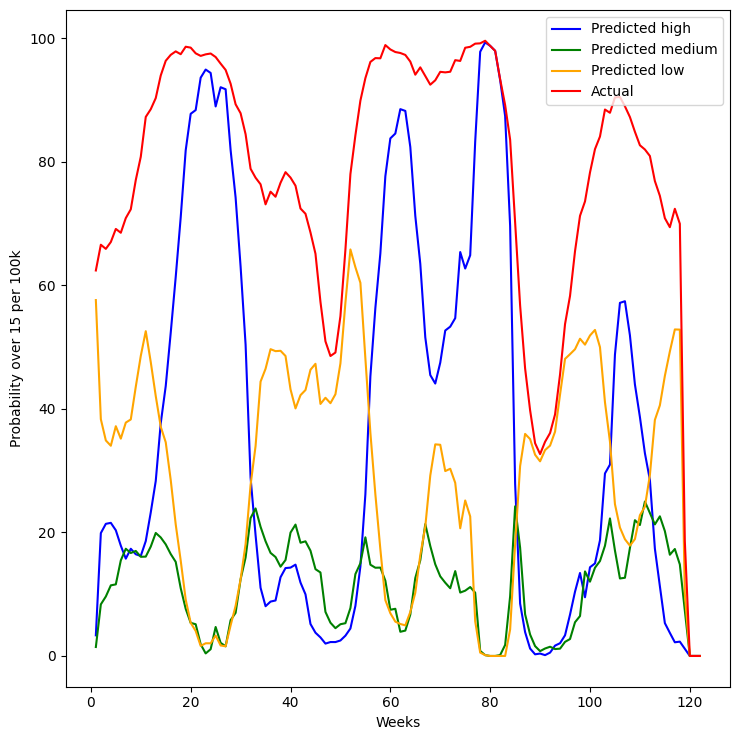

In [38]:
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


axs.plot(range(1,123), sum_high_and_1, color = 'blue', label = 'Predicted high')
axs.plot(range(1,123), sum_med_and_1, color = 'green', label = 'Predicted medium')
axs.plot(range(1,123), sum_low_and_1, color = 'orange', label = 'Predicted low')

axs.plot(range(1,123), actual_1, color = 'red', label = 'Actual')
axs.legend()
axs.set_xlabel("Weeks")
axs.set_ylabel("Probability over 15 per 100k")
plt.tight_layout()

plt.savefig('Graphs/CDC_predicted_vs_actual.png', dpi = 300)

Convert X data to 0 and 1 (0 = low/medium, 1 = high) and get confusion matrix  

In [90]:
X_train_converted = np.where(X_train[1] == "High", 1, 0)
confusion_matrix(X_train_converted, y_train)

#accuracy 
print("accuracy: ", accuracy_score(X_train_converted, y_train))

# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

accuracy:  0.5738544567048228
sensitivity:  0.42439316595478693
specificity:  0.9605184965086911
ppv:  0.9684129200962767
npv:  0.3691106575510612


## Can make a decision tree using the raw data, rather than the CDC cutoffs

In [91]:
### this code it's exactly in  x weeks 
def prep_training_test_data(data, proportion, no_weeks, weeks_in_futre, if_train, geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]
            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15

            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and  "target" for that week

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -2)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)


In [92]:
column_names = ['HSA_ID']
categories_for_subsetting = ['cases', 'admits', 'percent_beds_covid']

for week in range(1, len(data_by_HSA_cases_admits_perc) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)

data_by_HSA_cases_admits_perc_weekly = pd.DataFrame(index=range(51), columns=column_names)

x = 0

for HSA in data_by_HSA['HSA_ID'].unique():
    matching_indices = [i for i, HSA_col in enumerate(data_by_HSA_cases_admits_perc) if HSA_col == HSA]
    data_by_HSA_cases_admits_perc_weekly.loc[x, 'HSA_ID'] = HSA
    columns_to_subset =  [f'{HSA}_{category}' for category in categories_for_subsetting]
 
    j = 1
    try:
        for row in range(len(data_by_HSA_cases_admits_perc.loc[:, columns_to_subset])):
            data_by_HSA_cases_admits_perc_weekly.iloc[x, j:j + len(categories_for_subsetting)] = data_by_HSA_cases_admits_perc.loc[row,columns_to_subset]
            j += len(categories_for_subsetting)
    except:
        pass
    x += 1

In [93]:

data_by_HSA_cases_admits_perc_outcome = pd.merge(data_by_HSA_cases_admits_perc_weekly, all_HSA_ID_weekly_data,left_index=True, right_index=True) ## have to add outcomes

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
data_by_HSA_cases_admits_perc_outcome = data_by_HSA_cases_admits_perc_outcome.join(weights_df['weight'])

In [94]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(data_by_HSA_cases_admits_perc_outcome, [3,2], no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID_x', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(data_by_HSA_cases_admits_perc_outcome, [3,2], no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID_x',  weight_col = 'weight')
weights = weights[0]

In [148]:
# Create a decision tree classifier

param_grid = {
    'criterion': ['gini'],#,  'entropy'],
    'max_depth': np.arange(3, 4),
    'min_samples_split':  np.arange(50, 150), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(1, 100), #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': 7.39623022e-05}
    'ccp_alpha': np.arange(0.000001, 0.00001, 0.000001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test[0], y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names = ['cases', 'admits', 'percent_beds_covid'],  filled=True)
plt.savefig('Graphs/Optimized_CDC_classifier.png', dpi = 300)

In [147]:
best_params

{'min_samples_split': 59,
 'min_samples_leaf': 41,
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 9e-06}

Number of nodes in the last tree is: 1 with ccp_alpha: 0.17422937397847071


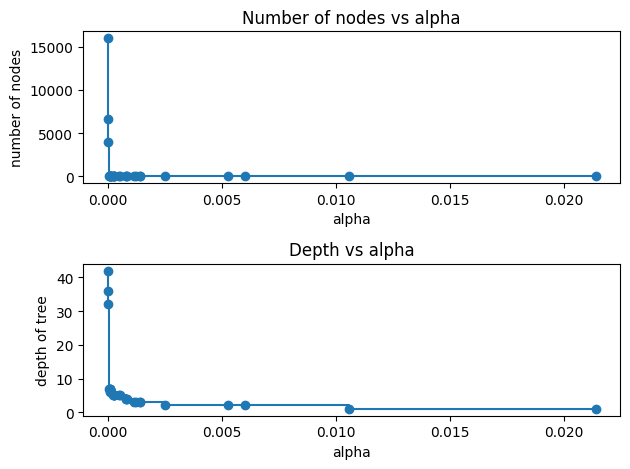

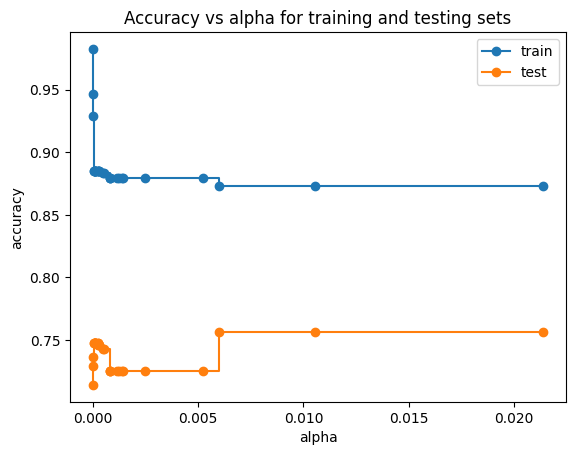

In [143]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=10, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

[Text(0.4, 0.8333333333333334, 'percent_beds_covid <= 0.021\nentropy = 1.0\nsamples = 65846\nvalue = [41.0, 41.0]'),
 Text(0.2, 0.5, 'entropy = 0.669\nsamples = 16512\nvalue = [30.566, 6.476]'),
 Text(0.6, 0.5, 'percent_beds_covid <= 0.057\nentropy = 0.782\nsamples = 49334\nvalue = [10.434, 34.524]'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.966\nsamples = 17854\nvalue = [7.608, 11.775]'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.501\nsamples = 31480\nvalue = [2.826, 22.748]')]

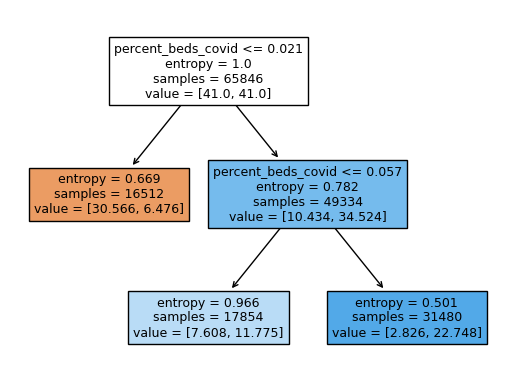

In [124]:
plot_tree(clf, feature_names = ['cases', 'admits', 'percent_beds_covid'],  filled=True)


In [130]:
best_params

{'min_samples_split': 139,
 'min_samples_leaf': 28,
 'max_depth': 4,
 'criterion': 'gini',
 'ccp_alpha': 0.023399999999999966}

In [111]:
# Convert predicted probabilities to binary predictions using a threshold (e.g., 0.5)

# Calculate AUROC

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)


sensitivity:  0.7652963211987321
specificity:  0.7438780371605527
ppv:  0.8556623530043495
npv:  0.6150149677012762


## which weeks had the highest predictive capacity 
- have the same temporal split
- need to have the same model from each of them (ABOVE MODEL)

In [131]:
weeks_to_predict = range(0,4) ## three being the actual prediction week 
ROC_by_week = []
#
for prediction_week in weeks_to_predict: 
    
    X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(data_by_HSA_cases_admits_perc_outcome, [3,2], no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID_x', weight_col = 'weight')

    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(data_by_HSA_cases_admits_perc_outcome, [3,2], no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID_x',  weight_col = 'weight')
    weights = weights[0]
    clf.fit(X_train, y_train[0],  sample_weight = weights)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test[0], y_pred)
    ROC_by_week.append(roc_auc_score(y_test[0], y_pred))
        

In [132]:
ROC_by_week

[0.9169298270095798,
 0.8090210751552396,
 0.7545871791796425,
 0.7176427758775072]